In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from dotenv import load_dotenv 
import random
import numpy as np
import torch
from PIL import Image
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually

import open_clip

import transformers
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# loading variables from .env file
load_dotenv("../../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")

WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")

MERGED_DATA_VALIDATION_SET = PARENT + os.getenv("MERGED_DATA_VALIDATION_SET")
MERGED_DATA_TESTING_SET = PARENT + os.getenv("MERGED_DATA_TESTING_SET")

In [4]:
def fixPath(path):
    return path.replace(".././", "../")

filtered_data_downloaded = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)

def get_image_path_from_recordID(recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = filtered_data_downloaded[
        filtered_data_downloaded["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

I will have to do the same for testing set when done !

In [5]:
MERGED_DATA_VALIDATION = pd.read_csv(MERGED_DATA_VALIDATION_SET)
MERGED_DATA_VALIDATION

,recordID,category,focus,caption,length_tokenization
0,5002,Tableau,luminosity,"Une fête, un repas, une foule en intérieur, de...",30
1,10900,Tableau,luminosity,"Une femme joue du piano, elle lit une partitio...",36
2,5510,Dessin,luminosity,"Un adolescente est assise contre le mur, elle ...",28
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon...",22
4,7689,Tableau,emotion,"Des hommes barbus et moustachus qui discutent,...",26
...,...,...,...,...,...
958,4072,Tableau,content,"Portrait d'une jeune femme qui lit un livre, v...",24
959,1294,Tableau,emotion,Un paysage désolé avec des arbres sans feuille...,31
960,482,Tableau,colors,Portrait d'une jeune femme avec une robe noire...,33
961,8397,Dessin,emotion,"Des personnes marchent de dos dans un port, le...",32


In [6]:
#https://github.com/FreddeFrallan/Multilingual-CLIP

In [7]:
model_name = 'M-CLIP/XLM-Roberta-Large-Vit-B-16Plus'

# Load Model & Tokenizer
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
text_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
text_model = text_model.to(device)
text_model.eval()

MultilingualCLIP(
  (transformer): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024

In [8]:
# Verify that the pt_multilingual_clip has been modified to allow for device in forward
try:
    text_model.forward("test", text_tokenizer, device=device)
    print("GOOD: Model has been modified to allow for device in forward")
except:
    raise Exception("Model has not been modified to allow for device in forward !")

GOOD: Model has been modified to allow for device in forward


In [9]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

In [10]:
openclip_model_name = "ViT-B-16-plus-240"
openclip_pretrained = "laion400m_e32"

#openclip_model_name = "ViTamin-XL-384"
#openclip_pretrained = "datacomp1b"
# ==> Better results than ViT-B-16-plus-240 but not avaialble in pt_multilingual_clip

model, _, preprocess = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
openclip_tokenizer = open_clip.get_tokenizer(openclip_model_name)
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [11]:
class ImageTextDataset(Dataset):
    def __init__(self, dataframe, preprocess):
        self.dataframe = dataframe
        self.preprocess = preprocess

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        path = get_image_path_from_recordID(row['recordID']) 
        image = Image.open(path)
        image = self.preprocess(image)  
        
        text = row['caption']
        return image, text

dataset = ImageTextDataset(MERGED_DATA_VALIDATION, preprocess)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

print(len(dataset), len(dataloader))

963 482


In [12]:
def get_text_embeddings_MCLIP(model, tokenizer, dataloader, device):
    text_embeddings = []

    #model.device = device

    for _, texts in tqdm(dataloader): 
        with torch.no_grad():
            embeddings = model.forward(texts, tokenizer, device=device) # Note: add device parameter to forward manually

        text_embeddings.append(embeddings)

    text_embeddings = torch.cat(text_embeddings, dim=0)
    # Normalize embeddings
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
    return text_embeddings

text_embeddings_MCLIP = get_text_embeddings_MCLIP(text_model, text_tokenizer, dataloader, device)
text_embeddings_MCLIP.shape

100%|██████████| 482/482 [00:13<00:00, 35.66it/s]


torch.Size([963, 640])

In [13]:
def get_text_embeddings_OpenCLIP(model, tokenizer, dataloader, device):
    text_embeddings = []

    for images, texts in tqdm(dataloader): 
        texts = tokenizer(texts).to(device)
        with torch.no_grad():
            embeddings = model.encode_text(texts)

        text_embeddings.append(embeddings)

    text_embeddings = torch.cat(text_embeddings, dim=0)
    # Normalize embeddings
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)
    return text_embeddings

text_embeddings_OpenCLIP = get_text_embeddings_OpenCLIP(model, openclip_tokenizer, dataloader, device)
text_embeddings_OpenCLIP.shape

100%|██████████| 482/482 [00:08<00:00, 53.78it/s]


torch.Size([963, 640])

In [14]:
def get_image_embeddings(model, dataloader):
    image_embeddings = []
    for images, _ in tqdm(dataloader):
        images = images.to(device)
        with torch.no_grad():
            image_features = model.encode_image(images)
        image_embeddings.append(image_features)
    image_embeddings = torch.cat(image_embeddings)
    # Normalize embeddings
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
    return image_embeddings

image_embeddings = get_image_embeddings(model, dataloader)
image_embeddings.shape

100%|██████████| 482/482 [00:09<00:00, 51.61it/s]


torch.Size([963, 640])

In [83]:
class ImageOnlyDataset(Dataset):
    def __init__(self, dataframe, preprocess):
        self.dataframe = dataframe
        self.preprocess = preprocess

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        path = get_image_path_from_recordID(row['recordID']) 
        try:
            image = Image.open(path)
        except:
            print(row['recordID'])
            raise Exception("Image not found")
        return self.preprocess(image), 0

FULL_DATASET = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
# Remove rows with corrupted images
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 11546]
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 5262]
FULL_DATASET

full_dataset = ImageOnlyDataset(FULL_DATASET, preprocess)
full_dataloader = DataLoader(full_dataset, batch_size=2, shuffle=False)

full_image_embeddings = get_image_embeddings(model, full_dataloader)
full_image_embeddings.shape

100%|██████████| 1505/1505 [00:28<00:00, 53.44it/s]


torch.Size([3010, 640])

In [84]:
# Calculate cosine similarity between all image-text pairs
# Intra = With only the images used in the set (validation/testing)
cosine_similarities_MCLIP_intra = {}
cosine_similarities_OpenCLIP_intra = {}

# Extra = With all the images
cosine_similarities_MCLIP_all = {}
cosine_similarities_OpenCLIP_all = {}

# Intra
for focus in ["content", "colors", "emotion", "luminosity"]:
    indices_of_focus = MERGED_DATA_VALIDATION[MERGED_DATA_VALIDATION["focus"] == focus].index
    
    text_embeddings_focus_MCLIP = text_embeddings_MCLIP[indices_of_focus]
    text_embeddings_focus_OpenCLIP = text_embeddings_OpenCLIP[indices_of_focus]

    image_embeddings_focus = image_embeddings[indices_of_focus]

    # Calculate cosine similarity between all image-text pairs
    if openclip_model_name == "ViT-B-16-plus-240":
        cosine_similarities_MCLIP_intra[focus] = cosine_similarity(image_embeddings_focus.cpu().numpy(), text_embeddings_focus_MCLIP.cpu().numpy())
    else:
        # Generate dummy values
        cosine_similarities_MCLIP_intra[focus] = np.random.rand(image_embeddings_focus.shape[0], text_embeddings_focus_MCLIP.shape[0])

    cosine_similarities_OpenCLIP_intra[focus] = cosine_similarity(image_embeddings_focus.cpu().numpy(), text_embeddings_focus_OpenCLIP.cpu().numpy())

# Extra
for focus in ["content", "colors", "emotion", "luminosity"]:
    indices_of_focus = MERGED_DATA_VALIDATION[MERGED_DATA_VALIDATION["focus"] == focus].index
    
    text_embeddings_focus_MCLIP = text_embeddings_MCLIP[indices_of_focus]
    text_embeddings_focus_OpenCLIP = text_embeddings_OpenCLIP[indices_of_focus]

    image_embeddings_focus = full_image_embeddings[indices_of_focus]

    # Calculate cosine similarity between all image-text pairs
    if openclip_model_name == "ViT-B-16-plus-240":
        cosine_similarities_MCLIP_all[focus] = cosine_similarity(image_embeddings_focus.cpu().numpy(), text_embeddings_focus_MCLIP.cpu().numpy())
    else:
        # Generate dummy values
        cosine_similarities_MCLIP_all[focus] = np.random.rand(image_embeddings_focus.shape[0], text_embeddings_focus_MCLIP.shape[0])

    cosine_similarities_OpenCLIP_all[focus] = cosine_similarity(image_embeddings_focus.cpu().numpy(), text_embeddings_focus_OpenCLIP.cpu().numpy())

In [87]:
def get_MRR(cosine_similarities):
    """
    What is MRR (Mean Reciprocal Rank)?
    ==> The Mean Reciprocal Rank is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the reciprocal ranks of the top k items.
    ==> The reciprocal rank of a query response is the multiplicative inverse of the rank of the first correct answer.
    ==> The MRR is a number between 0 and 1, where 1 means that the first correct answer is always ranked first.
    """
    mrr = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        mrr += 1 / rank
    mrr /= len(cosine_similarities)
    return mrr

def get_average_position(cosine_similarities):
    """
    What is the Average Position?
    ==> The Average Position is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the positions of the correct answers.
    ==> The position of a query response is the rank of the first correct answer.
    ==> The Average Position is a number between 0 and n, where 0 means that the first correct answer is always ranked first.
    """
    average_position = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        average_position += rank
    average_position /= len(cosine_similarities)
    return average_position

def get_recall_at_k(cosine_similarities, k):
    """
    What is Recall@k?
    ==> The Recall@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the proportion of the top k items that are relevant.
    ==> The Recall@k is a number between 0 and 1, where 1 means that all top k items are relevant.
    """
    recall_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        if i in sorted_indices[:k]:
            recall_at_k += 1
    recall_at_k /= len(cosine_similarities)
    return recall_at_k

def get_nDCG_at_k(cosine_similarities, k):
    """
    What is nDCG@k (Discounted cumulative gain)
    ==> The nDCG@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the normalized discounted cumulative gain at the top k items.
    ==> The nDCG@k is a number between 0 and 1, where 1 means that all top k items are relevant and perfectly ranked.
    """
    nDCG_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        nDCG_at_k += 1 / np.log2(rank + 1) if rank <= k else 0
    nDCG_at_k /= len(cosine_similarities)
    return nDCG_at_k

def get_benchmarks(cosine_similarities_OpenCLIP, cosine_similarities_MCLIP):
    total_benchmark = pd.DataFrame(columns=[
        "MRR",
        "Average Position",
        "Recall@1",
        "Recall@3",
        "nDCG@1",
        "nDCG@3",
    ], dtype=float)
    total_benchmark.loc["Open-clip"] = [
        0,
        0,
        0,
        0,
        0,
        0,    
    ]
    total_benchmark.loc["M-CLIP"] = [
        0,
        0,
        0,
        0,
        0,
        0,    
    ]

    benchmarks = {}

    for focus in ["content", "colors", "emotion", "luminosity"]:

        benchmark = pd.DataFrame(columns=[
            "MRR",
            "Average Position",
            "Recall@1",
            "Recall@3",
            "nDCG@1",
            "nDCG@3",
        ], dtype=float)


        benchmark.loc["Open-clip"] = [
            get_MRR(cosine_similarities_OpenCLIP[focus]),
            get_average_position(cosine_similarities_OpenCLIP[focus]),
            get_recall_at_k(cosine_similarities_OpenCLIP[focus], 1),
            get_recall_at_k(cosine_similarities_OpenCLIP[focus], 3),
            get_nDCG_at_k(cosine_similarities_OpenCLIP[focus], 1),
            get_nDCG_at_k(cosine_similarities_OpenCLIP[focus], 3),
        ]

        benchmark.loc["M-CLIP"] = [
            get_MRR(cosine_similarities_MCLIP[focus]),
            get_average_position(cosine_similarities_MCLIP[focus]),
            get_recall_at_k(cosine_similarities_MCLIP[focus], 1),
            get_recall_at_k(cosine_similarities_MCLIP[focus], 3),
            get_nDCG_at_k(cosine_similarities_MCLIP[focus], 1),
            get_nDCG_at_k(cosine_similarities_MCLIP[focus], 3),
        ]

        total_benchmark.loc["Open-clip"] += benchmark.loc["Open-clip"]
        total_benchmark.loc["M-CLIP"] += benchmark.loc["M-CLIP"]
        
        benchmarks[focus] = benchmark

    # Divide by 4 to get the average
    total_benchmark /= 4
    return benchmarks, total_benchmark

intra_benchmarks, intra_total_benchmark = get_benchmarks(cosine_similarities_OpenCLIP_intra, cosine_similarities_MCLIP_intra)
extra_benchmarks, extra_total_benchmark = get_benchmarks(cosine_similarities_OpenCLIP_all, cosine_similarities_MCLIP_all)

print("Intra:")
print(intra_total_benchmark)

print("Extra:")
print(extra_total_benchmark)

C:\Users\victo\AppData\Local\Temp\ipykernel_2356\164752181.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5366535406869032' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  total_benchmark.loc["Open-clip"] += benchmark.loc["Open-clip"]
C:\Users\victo\AppData\Local\Temp\ipykernel_2356\164752181.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.445414847161572' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  total_benchmark.loc["Open-clip"] += benchmark.loc["Open-clip"]
C:\Users\victo\AppData\Local\Temp\ipykernel_2356\164752181.py:121: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.39737991266375544' has dtype incompatible with int64, please explic

Intra:
                MRR  Average Position  Recall@1  Recall@3    nDCG@1    nDCG@3
Open-clip  0.535889          8.352409  0.384199  0.628886  0.384199  0.527439
M-CLIP     0.634031          5.168253  0.498189  0.724256  0.498189  0.631312
Extra:
                MRR  Average Position  Recall@1  Recall@3    nDCG@1    nDCG@3
Open-clip  0.023736        121.349658  0.001851  0.007300  0.001851  0.004661
M-CLIP     0.024579        120.227601  0.001092  0.009381  0.001092  0.005765


In [68]:
# Get unique image embeddings
image_embeddings_indice_to_recordID = {}
for idx, recordID in enumerate(FULL_DATASET["recordID"]):
    image_embeddings_indice_to_recordID[idx] = recordID

In [76]:
def MCLIP_queries_embedder(text_model, text_tokenizer, device, normalize=True):
    def embedder(queries, weights):
        text_model.eval()

        with torch.no_grad():
            query_embedding = torch.zeros((1, 640)).to(device)
            for i, query in enumerate(queries):
                part = weights[i] * text_model.forward(query, text_tokenizer, device=device) # Note: add device parameter to forward manually
                query_embedding += part

        # Normalize
        if normalize:
            query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)

        return query_embedding

    return embedder

def OpenCLIP_queries_embedder(model, tokenizer, device, normalize=True):
    def embedder(queries, weights):
        model.eval()

        with torch.no_grad():
            query_embedding = torch.zeros((1, 640)).to(device)
            for i, query in enumerate(queries):
                query = tokenizer(query).to(device)
                part = weights[i] * model.encode_text(query)
                query_embedding += part

        # Normalize
        if normalize:
            query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)

        return query_embedding

    return embedder

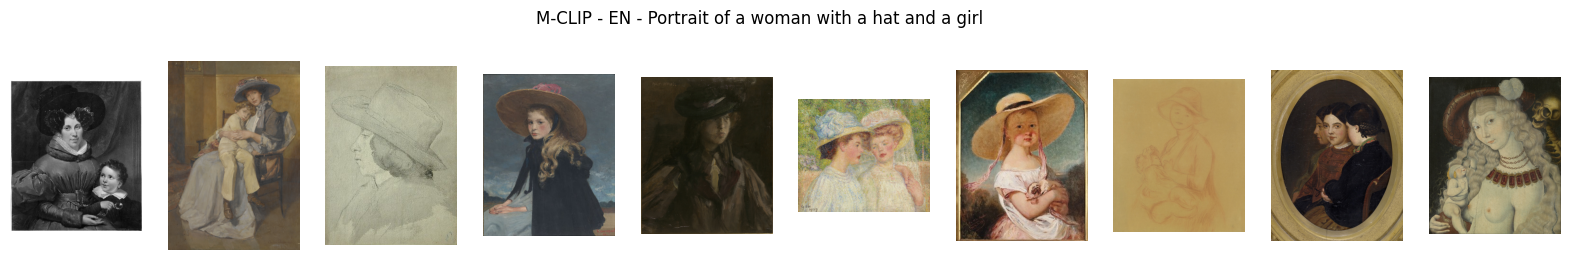

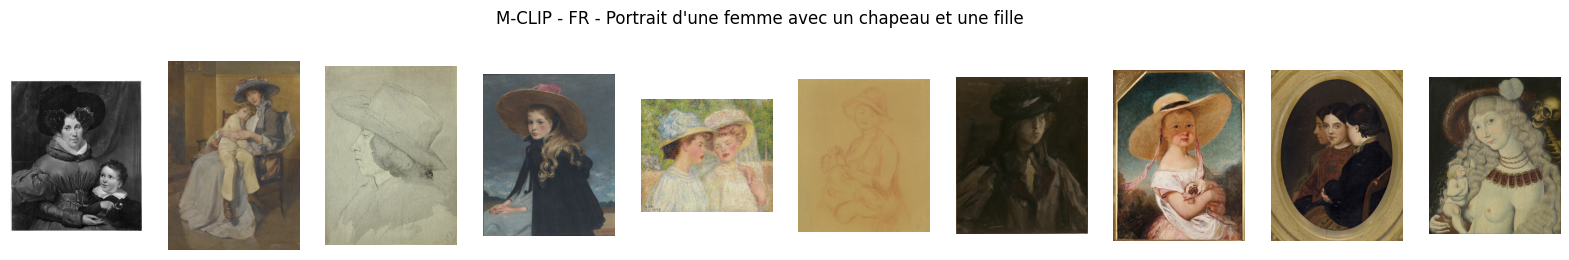

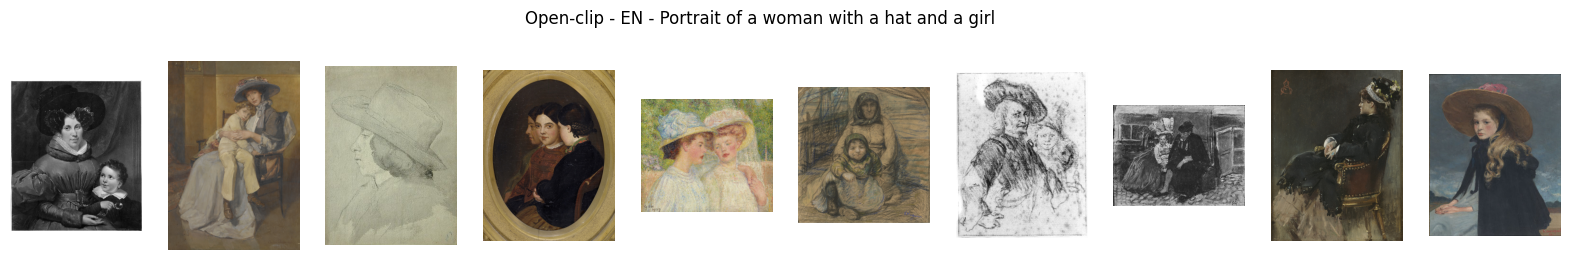

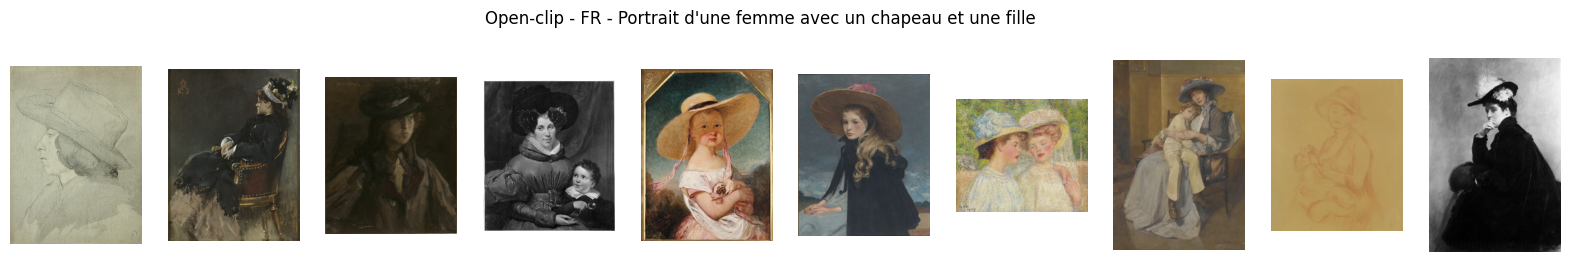

In [77]:
def query_k(query, embedder, image_embeddings, index_to_recordID, k=5):
    query_embedding = embedder([query], [1])

    # Calculate cosine similarity between the query and all image-text pairs
    # Shape: torch.Size([229, 640]) torch.Size([1, 640])
    cosine_similarities = cosine_similarity(image_embeddings.cpu().numpy(), query_embedding.cpu().numpy())

    # Get the indices of the top k most similar image-text pairs
    sorted_indices = np.argsort(cosine_similarities.flatten())[::-1][:k]

    # Get the paths of the top k most similar images
    paths = []
    for i in sorted_indices:
        recordID = index_to_recordID[i]
        path = get_image_path_from_recordID(recordID)
        paths.append(path)

    return paths

# Test
query_per_lang = {
    "EN": "Portrait of a woman with a hat and a girl",
    "FR": "Portrait d'une femme avec un chapeau et une fille",
}

embedder_MCLIP = MCLIP_queries_embedder(text_model, text_tokenizer, device, normalize=True)
embedder_OpenCLIP = OpenCLIP_queries_embedder(model, openclip_tokenizer, device, normalize=True)

embedders = {
    "M-CLIP": embedder_MCLIP,
    "Open-clip": embedder_OpenCLIP,
}

for embedderName in embedders.keys():
    embedder = embedders[embedderName]
    for lang, query in query_per_lang.items():
        paths = query_k(query, embedder, full_image_embeddings, image_embeddings_indice_to_recordID, k=10) 

        fig, ax = plt.subplots(1, len(paths), figsize=(20, 3))
        fig.suptitle(f"{embedderName} - {lang} - {query}")
        for i, path in enumerate(paths):
            image = Image.open(path)
            ax[i].imshow(image, cmap="gray")
            ax[i].axis("off")
        plt.show()

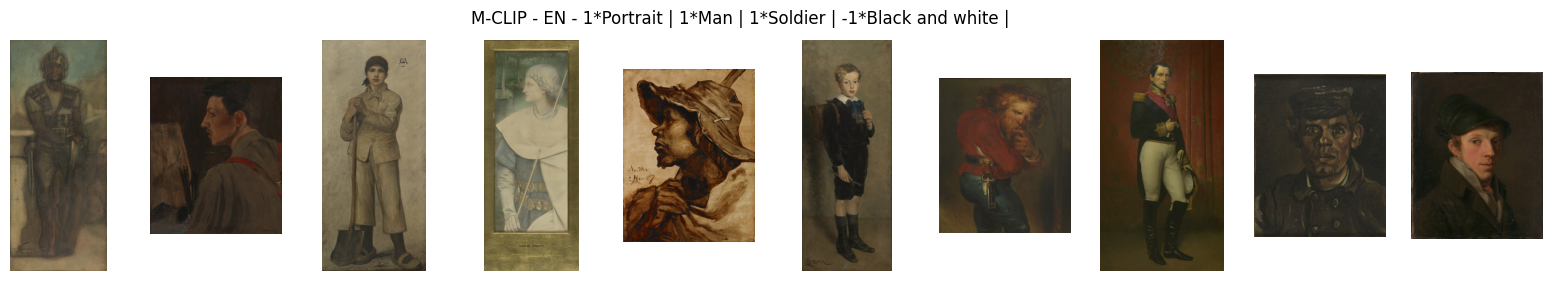

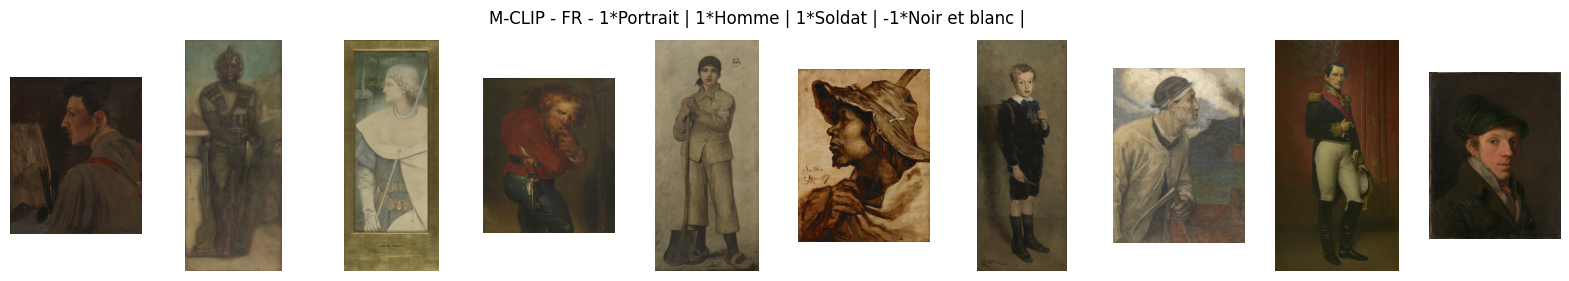

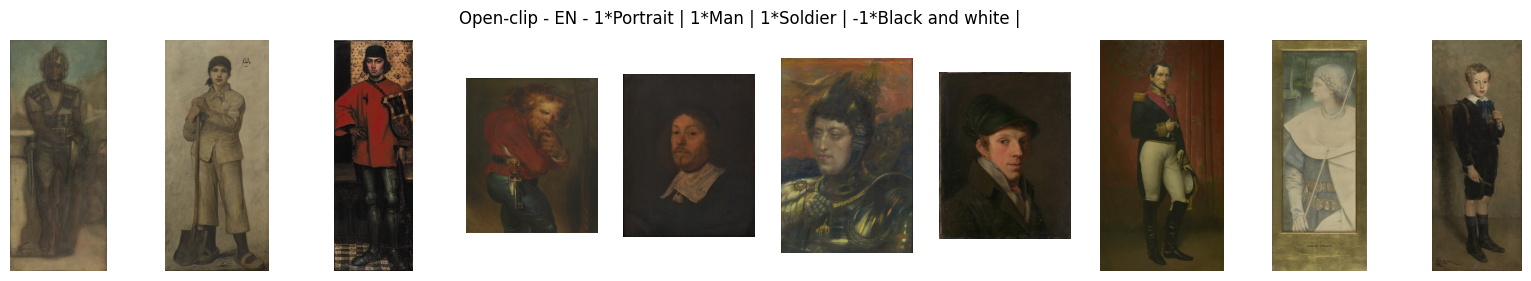

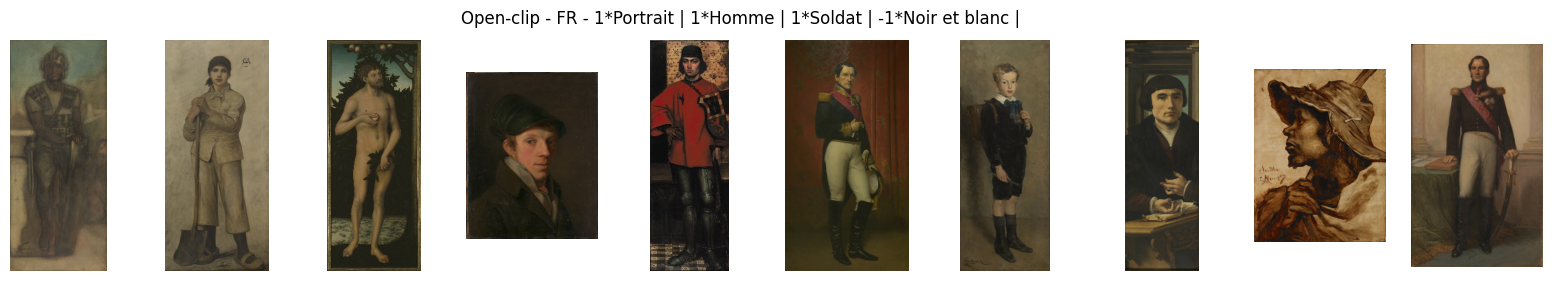

In [82]:
def multi_query_k(queries, weights, embedder, image_embeddings, index_to_recordID, k=5):
    assert len(queries) == len(weights), "The number of queries and weights must be the same."
    query_embedding = embedder(queries, weights)

    # Calculate cosine similarity between the query and all image-text pairs
    # Shape: torch.Size([229, 640]) torch.Size([1, 640])
    cosine_similarities = cosine_similarity(image_embeddings.cpu().numpy(), query_embedding.cpu().numpy())

    # Get the indices of the top k most similar image-text pairs
    sorted_indices = np.argsort(cosine_similarities.flatten())[::-1][:k]

    # Get the paths of the top k most similar images
    paths = []
    for i in sorted_indices:
        recordID = index_to_recordID[i]
        path = get_image_path_from_recordID(recordID)
        paths.append(path)

    return paths

# Test

queries_per_lang = {
    "EN": [
        "Portrait",
        "Man",
        "Soldier",
        "Black and white",
    ],
    "FR": [
        "Portrait",
        "Homme",
        "Soldat",
        "Noir et blanc",
    ],
}

weights = [1, 1, 1, -1]

embedder_MCLIP = MCLIP_queries_embedder(text_model, text_tokenizer, device, normalize=True)
embedder_OpenCLIP = OpenCLIP_queries_embedder(model, openclip_tokenizer, device, normalize=True)

embedders = {
    "M-CLIP": embedder_MCLIP,
    "Open-clip": embedder_OpenCLIP,
}

for embedderName in embedders.keys():
    embedder = embedders[embedderName]
    for lang, queries in queries_per_lang.items():
        paths = multi_query_k(queries, weights, embedder, full_image_embeddings, image_embeddings_indice_to_recordID, k=10) 

        queryAsText = ""
        for i in range(len(queries)):
            queryAsText += f"{weights[i]}*{queries[i]} | "

        fig, ax = plt.subplots(1, len(paths), figsize=(20, 3))
        fig.suptitle(f"{embedderName} - {lang} - {queryAsText}")
        for i, path in enumerate(paths):
            image = Image.open(path)
            ax[i].imshow(image, cmap="gray")
            ax[i].axis("off")
        plt.show()